In [12]:
import sys
import time
from pathlib import Path
from typing import List, Dict, Any, Optional, Tuple

import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import pandas as pd
import matplotlib.pyplot as plt

# Assuming your directory structure is maintained
sys.path.append(str(Path("..").resolve()))
from data_handling import load_measurements_npz, MeasurementDataset, MeasurementLoader
# We still import HyperRBM and tools for the "Joint" part of the experiment
from hyper_rbm import SymmetricHyperRBM, train_loop, get_sigmoid_curve
from wavefunction_overlap import generate_basis_states, calculate_exact_overlap, load_gt_wavefunction

data_dir = Path("measurements")
state_dir = Path("state_vectors")
results_dir = Path("results")
results_dir.mkdir(parents=True, exist_ok=True)

device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Running on: {device}")

Running on: cpu


In [13]:
class SymmetricRBM(nn.Module):
    def __init__(self, num_v: int, num_h: int, k: int = 10):
        super().__init__()
        self.num_v = num_v
        self.num_h = num_h
        self.k = k
        self.T = 1.0

        self.W = nn.Parameter(torch.empty(num_v, num_h))
        self.b = nn.Parameter(torch.zeros(num_v))
        self.c = nn.Parameter(torch.zeros(num_h))

        self.initialize_weights()

    def initialize_weights(self, std: float = 0.01):
        nn.init.normal_(self.W, std=std)
        nn.init.constant_(self.b, 0.0)
        nn.init.constant_(self.c, 0.0)

    def _free_energy(self, v: torch.Tensor) -> torch.Tensor:
        v = v.to(dtype=self.W.dtype, device=self.W.device)

        # Use static biases directly
        b = self.b.unsqueeze(0) # (1, V)
        c = self.c.unsqueeze(0) # (1, H)

        # precompute shared terms
        vW = v @ self.W                  # (B, H)
        W_colsum = self.W.sum(dim=0)     # (H,)

        # calculate the free energies for both branches (u=1 and u=0)
        preact_normal  = vW + c
        preact_flipped = (W_colsum.unsqueeze(0) - vW) + c

        sp_normal  = F.softplus(preact_normal).sum(dim=-1)
        sp_flipped = F.softplus(preact_flipped).sum(dim=-1)

        vb_normal  = -(v * b).sum(dim=-1)
        vb_flipped = -((1.0 - v) * b).sum(dim=-1)

        F_normal  = vb_normal  - sp_normal
        F_flipped = vb_flipped - sp_flipped

        negF = torch.stack([-F_normal, -F_flipped], dim=-1)
        return -self.T * torch.logsumexp(negF / self.T, dim=-1)

    def _gibbs_step(self, v, h, u, rng: Optional[torch.Generator], T: float):
        # Use static biases
        b = self.b.unsqueeze(0)
        c = self.c.unsqueeze(0)

        # pick branch
        v_branch = u * v + (1.0 - u) * (1.0 - v)

        # step 1: h | v, u
        p_h = torch.sigmoid((v_branch @ self.W + c) / T)
        h = torch.bernoulli(p_h, generator=rng)

        a = h @ self.W.t()

        # step 2: u | v, h
        vb = (v * b).sum(dim=-1)
        va = (v * a).sum(dim=-1)
        bsum = b.sum(dim=-1)
        asum = a.sum(dim=-1)

        dE = (-bsum - asum + 2.0 * vb + 2.0 * va)
        p_u = torch.sigmoid(dE / T)
        u = torch.bernoulli(p_u, generator=rng).to(v.dtype).unsqueeze(-1)

        # step 3: v | h, u
        p_v_branch = torch.sigmoid((a + b) / T)
        v_branch_new = torch.bernoulli(p_v_branch, generator=rng)

        v_next = u * v_branch_new + (1.0 - u) * (1.0 - v_branch_new)

        return v_next, h, u

    def log_score(self, v: torch.Tensor, cond: Optional[torch.Tensor] = None) -> torch.Tensor:
        # cond argument is kept for API compatibility but ignored
        return -0.5 * self._free_energy(v) / self.T

    def forward(self, batch: Tuple[torch.Tensor, ...], aux_vars: Dict[str, Any]):
        rng = aux_vars.get("rng")

        # We ignore 'cond' from the batch for the standard RBM
        v_data, _, _ = batch
        v_data = v_data.to(device=self.W.device, dtype=self.W.dtype)

        v_model = v_data.clone()
        noise_frac = aux_vars.get("noise_frac", 0.0)
        num_reset_chains = int(v_data.size(0) * noise_frac)

        if num_reset_chains > 0:
            v_model[:num_reset_chains].bernoulli_(0.5, generator=rng)

        B = v_model.size(0)
        u = torch.bernoulli(torch.full((B, 1), 0.5, device=v_model.device, dtype=v_model.dtype), generator=rng)
        h = torch.zeros((B, self.num_h), device=v_model.device, dtype=v_model.dtype)

        for _ in range(self.k):
            v_model, h, u = self._gibbs_step(v_model, h, u, rng, T=self.T)
        v_model = v_model.detach()

        loss = self._free_energy(v_data).mean() - self._free_energy(v_model).mean()
        return loss, {}

In [14]:
def train_experiment_model(file_paths: List[Path], n_samples: int, config: Dict[str, Any],
                           rng: torch.Generator, device: torch.device,
                           model_type: str = "hyper") -> nn.Module:

    dataset = MeasurementDataset(file_paths, load_measurements_npz, ["h"], [n_samples] * len(file_paths))
    loader = MeasurementLoader(dataset, batch_size=config["batch_size"], shuffle=True, drop_last=False, rng=rng)

    if model_type == "hyper":
        model = SymmetricHyperRBM(num_v=dataset.num_qubits, num_h=config["num_hidden"],
                                  hyper_dim=config["hyper_dim"], k=config["k_steps"]).to(device)
    else:
        # Standard RBM doesn't need hyper_dim
        model = SymmetricRBM(num_v=dataset.num_qubits, num_h=config["num_hidden"],
                             k=config["k_steps"]).to(device)

    model.initialize_weights(std=config["init_std"])

    optimizer = torch.optim.Adam(model.parameters(), lr=config["init_lr"])

    steps = config["epochs"] * len(loader)
    scheduler = get_sigmoid_curve(config["init_lr"], config["final_lr"], steps, 0.005)

    model = train_loop(model, optimizer, loader, num_epochs=config["epochs"],
                       lr_schedule_fn=scheduler, noise_frac=config["gibbs_noise"], rng=rng)

    return model

def evaluate_overlap_sweep(model: nn.Module, h_values: List[float],
                           gt_wavefunctions: Dict[float, torch.Tensor], basis_states: torch.Tensor) -> List[float]:
    overlaps = []
    for h in h_values:
        psi_true = gt_wavefunctions[h]
        # model.log_score inside calculate_exact_overlap will handle ignoring h if it's the standard RBM
        ov = calculate_exact_overlap(model, h, psi_true, basis_states)
        overlaps.append(ov)

    return overlaps

In [15]:
SIDE_LENGTH = 4
FILE_SAMPLE_COUNT = 20_000
N_SAMPLES = 20_000

H_TRAIN = [1.00, 2.00, 3.00, 4.00, 5.00, 6.00, 7.00]
H_EVAL = [1.50, 2.50, 2.80, 3.20, 3.50, 4.50, 5.50, 6.50]
ALL_H = sorted(list(set(H_TRAIN + H_EVAL)))

SEED = 42
torch.manual_seed(SEED)

file_map = {h: data_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h:.2f}_{FILE_SAMPLE_COUNT}.npz"
            for h in H_TRAIN}
all_file_paths = [file_map[h] for h in H_TRAIN]

print("Pre-loading ground truth wavefunctions...")
all_states = generate_basis_states(SIDE_LENGTH**2, device)
gt_map = {}

for h_val in ALL_H:
    gt_path = state_dir / f"tfim_{SIDE_LENGTH}x{SIDE_LENGTH}_h{h_val:.2f}.npz"
    gt_map[h_val] = load_gt_wavefunction(gt_path, device)

print(f"Loaded {len(gt_map)} GT states.")

Pre-loading ground truth wavefunctions...
Loaded 15 GT states.


In [17]:
TRAIN_CONFIG = {
    "epochs": 50,
    "batch_size": 1024,
    "num_hidden": 64,
    "hyper_dim": 64, # Ignored by standard RBM
    "k_steps": 10,
    "init_lr": 1e-2,
    "final_lr": 1e-4,
    "gibbs_noise": 0.1,
    "init_std": 0.05
}

torch.manual_seed(SEED)
rng = torch.Generator().manual_seed(SEED)

# --- 1. Train Joint Hyper-RBM (All Data) ---
print(f"\n### TRAINING JOINT HYPER-MODEL (Samples per point: {N_SAMPLES}) ###")
# Explicitly requesting the hyper model
hyper_model = train_experiment_model(all_file_paths, N_SAMPLES, TRAIN_CONFIG, rng, device, model_type="hyper")

# Evaluate Joint model on ALL H values
print("Evaluating Joint Model...")
hyper_overlaps = evaluate_overlap_sweep(hyper_model, ALL_H, gt_map, all_states)

df_hyper = pd.DataFrame({"h": ALL_H, "overlap": hyper_overlaps})
df_hyper["type"] = df_hyper["h"].apply(lambda x: "support" if any(np.isclose(x, s) for s in H_TRAIN) else "novel")

# --- 2. Train Single Standard RBMs (One per Support Point) ---
single_overlaps = []
print(f"\n### TRAINING SINGLE STANDARD RBMs (Samples: {N_SAMPLES}) ###")

for h_val in H_TRAIN:
    print(f"  > Training individual Standard RBM for h={h_val:.2f}...")

    specific_path = [file_map[h_val]]

    # HERE IS THE CHANGE: model_type="standard"
    # This invokes the new SymmetricRBM class defined in Cell 2
    single_model = train_experiment_model(specific_path, N_SAMPLES, TRAIN_CONFIG, rng, device, model_type="standard")

    # Evaluate ONLY at this specific h
    psi_true = gt_map[h_val]
    ov = calculate_exact_overlap(single_model, h_val, psi_true, all_states)
    single_overlaps.append(ov)

df_single = pd.DataFrame({"h": H_TRAIN, "overlap": single_overlaps})

print("\nAll experiments finished.")
print(f"Mean Joint Overlap (Supports): {df_hyper[df_hyper['type']=='support']['overlap'].mean():.5f}")
print(f"Mean Single Overlap (Supports): {df_single['overlap'].mean():.5f}")


### TRAINING JOINT HYPER-MODEL (Samples per point: 20000) ###
Epoch  | Loss       | LR        
-----------------------------------
1      | +0.0400     | 0.010000
10     | +0.0099     | 0.010000
20     | +0.0088     | 0.009689
30     | +0.0009     | 0.000414
40     | -0.0029     | 0.000100
50     | -0.0010     | 0.000100
Evaluating Joint Model...

### TRAINING SINGLE STANDARD RBMs (Samples: 20000) ###
  > Training individual Standard RBM for h=1.00...
Epoch  | Loss       | LR        
-----------------------------------
1      | -1.9401     | 0.009180
10     | -0.0052     | 0.008201
20     | +0.0141     | 0.006274
30     | +0.0188     | 0.003849
40     | -0.0353     | 0.001913
50     | -0.0073     | 0.000854
  > Training individual Standard RBM for h=2.00...
Epoch  | Loss       | LR        
-----------------------------------
1      | +1.2657     | 0.009180
10     | -0.0095     | 0.008201
20     | -0.0147     | 0.006274
30     | +0.0193     | 0.003849
40     | -0.0061     | 0.001913
50

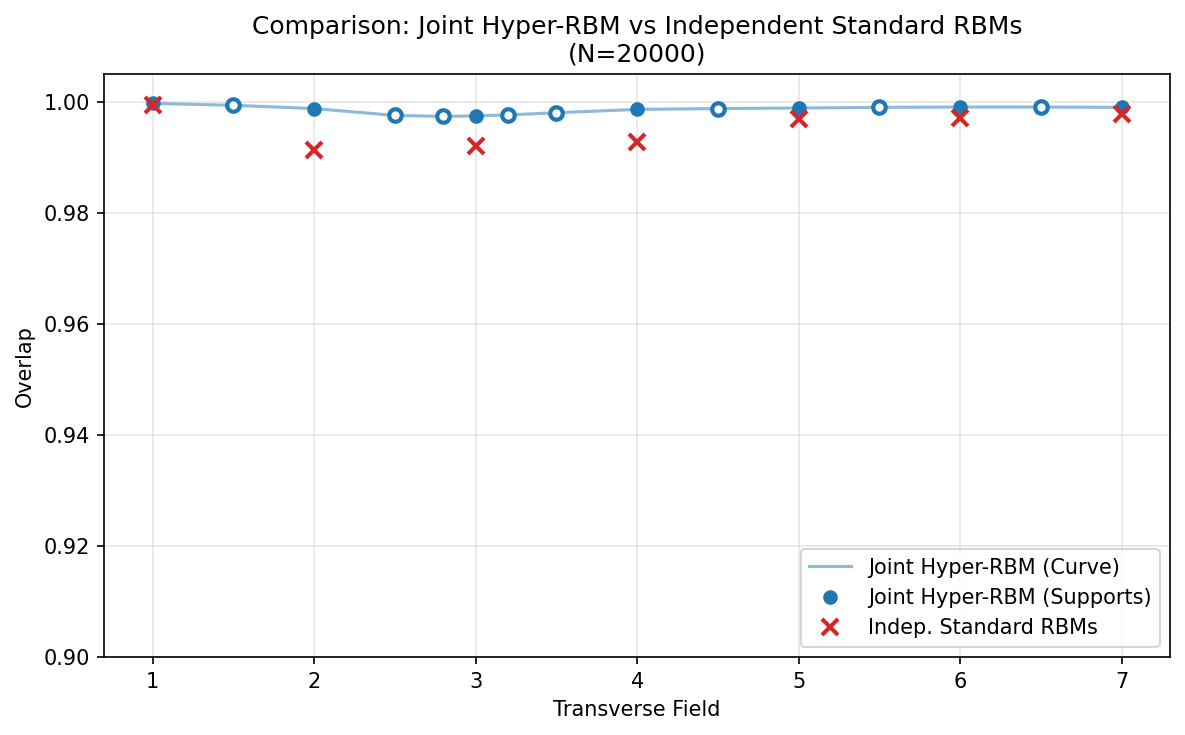

In [18]:
plt.figure(figsize=(8, 5), dpi=150)

# Extract subsets for the Joint Hyper Model
hyper_support = df_hyper[df_hyper["type"] == "support"]
hyper_novel = df_hyper[df_hyper["type"] == "novel"]

# 1. Plot the Joint Hyper Model
plt.plot(df_hyper["h"], df_hyper["overlap"], '-', color="C0", alpha=0.5, label="Joint Hyper-RBM (Curve)")
plt.plot(hyper_support["h"], hyper_support["overlap"], 'o', color="C0", label="Joint Hyper-RBM (Supports)")
plt.plot(hyper_novel["h"], hyper_novel["overlap"], 'o', color="C0", mfc='white', mew=2, markersize=6)

# 2. Plot the Single Independent Models
plt.plot(df_single["h"], df_single["overlap"], 'x', color="C3", markeredgewidth=2, markersize=8, label="Indep. Standard RBMs")

plt.xlabel("Transverse Field")
plt.ylabel("Overlap")
plt.title(f"Comparison: Joint Hyper-RBM vs Independent Standard RBMs\n(N={N_SAMPLES})")
plt.ylim(0.90, 1.005)
plt.grid(True, alpha=0.3)
plt.legend(loc='lower right')
plt.tight_layout()
plt.show()